In [2]:
import numpy as np
import pandas as pd
CLASSES=["Bull","Bear"]
LABEL_BULL = CLASSES.index("Bull")
LABEL_BEAR = CLASSES.index("Bear")

datasets = np.load("/content/drive/MyDrive/NEW_datasets.npz")
x_train, y_train = datasets["x_train"], datasets["y_train"]
x_val, y_val = datasets["x_val"], datasets["y_val"]
x_test, y_test = datasets["x_test"], datasets["y_test"]

label_distribution = pd.DataFrame([{"Dataset":"train",
                                   "Bull":np.count_nonzero(y_train==LABEL_BULL),
                                   "BEAR":np.count_nonzero(y_train==LABEL_BEAR)},
                                  {"Dataset":"val",
                                   "Bull":np.count_nonzero(y_val==LABEL_BULL),
                                   "BEAR":np.count_nonzero(y_val==LABEL_BEAR)},
                                  {"Dataset":"test",
                                   "Bull":np.count_nonzero(y_test==LABEL_BULL),
                                   "BEAR":np.count_nonzero(y_test==LABEL_BEAR)}
                                  ])
label_distribution

Dataset  Bull  BEAR
0   train   869   869
1     val   262   244
2    test   121   132

In [3]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, \
                                    BatchNormalization, Activation,\
                                    Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def inception_module(input_tensor):
    bottleneck = Conv1D(filters=32, kernel_size=1, padding="same", activation=None,
                       use_bias=False)(input_tensor)
    conv3 = Conv1D(filters=32, kernel_size=3, padding="same", activation=None,
                       use_bias=False)(input_tensor)
    conv5 = Conv1D(filters=32, kernel_size=5, padding="same", activation=None,
                       use_bias=False)(input_tensor)
    conv7 = Conv1D(filters=32, kernel_size=7, padding="same", activation=None,
                       use_bias=False)(input_tensor)
    mp = MaxPooling1D(pool_size=3, strides=1, padding="same")(input_tensor)
    mpbottleneck = Conv1D(filters=32, kernel_size=1, padding="same", activation=None,
                       use_bias=False)(input_tensor)
    x = Concatenate(axis=-1)([conv3, conv5, conv7, mpbottleneck])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def shortcut_layer(input_tensor1, input_tensor2):
    shortcut = Conv1D(filters=input_tensor2.shape[-1], kernel_size=1, padding="same",
                     activation=None, use_bias=False)(input_tensor1)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([shortcut, input_tensor2])
    x = Activation("relu")(x)
    return x
n_time_steps = x_train.shape[1]
n_features = x_train.shape[2]
input_layer = Input(shape=(n_time_steps, n_features))
x = input_layer
input_residual = input_layer
for i in range(6):
    x = inception_module(x)
    if i % 3==2:
        x = shortcut_layer(input_residual, x)
        input_residual = x
x = GlobalAveragePooling1D()(x)
output_layer = Dense(len(CLASSES), activation="softmax")(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 5)]             0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 100, 32)              480       ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 100, 32)              800       ['input_1[0][0]']             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 100, 32)              1120      ['input_1[0][0]']             
                                                                                              

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_checkpoint = ModelCheckpoint(filepath="best_model.hdf5", monitor="val_loss",
                                  save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)
callbacks = [model_checkpoint, early_stopping]
train_history = model.fit(x_train, to_categorical(y_train),
                         validation_data=(x_val, to_categorical(y_val)),
                         batch_size = 2048, epochs=1000, callbacks=[callbacks])

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 0.7385 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 21s 21s/step - loss: 0.7385 - accuracy: 0.5000 - val_loss: 24.6961 - val_accuracy: 0.5178
Epoch 2/1000
1/1 [==============================] - 1s 597ms/step - loss: 1.0678 - accuracy: 0.5017 - val_loss: 10.8101 - val_accuracy: 0.5178
Epoch 3/1000
1/1 [==============================] - 1s 593ms/step - loss: 0.7851 - accuracy: 0.5006 - val_loss: 1.9091 - val_accuracy: 0.4822
Epoch 4/1000
1/1 [==============================] - 0s 428ms/step - loss: 0.7040 - accuracy: 0.5000 - val_loss: 9.6995 - val_accuracy: 0.4822
Epoch 5/1000
1/1 [==============================] - 0s 457ms/step - loss: 0.7444 - accuracy: 0.5006 - val_loss: 12.3101 - val_accuracy: 0.4822
Epoch 6/1000
1/1 [==============================] - 0s 456ms/step - loss: 0.7316 - accuracy: 0.5000 - val_loss: 12.0985 - val_accuracy: 0.4822
Epoch 7/1000
1/1 [==============================] - 0s 468ms/step - loss: 0.7063 - accuracy: 0.4994 - val_loss: 10.7190 - val_accuracy: 0.4822
Epoch 8/1000
1/

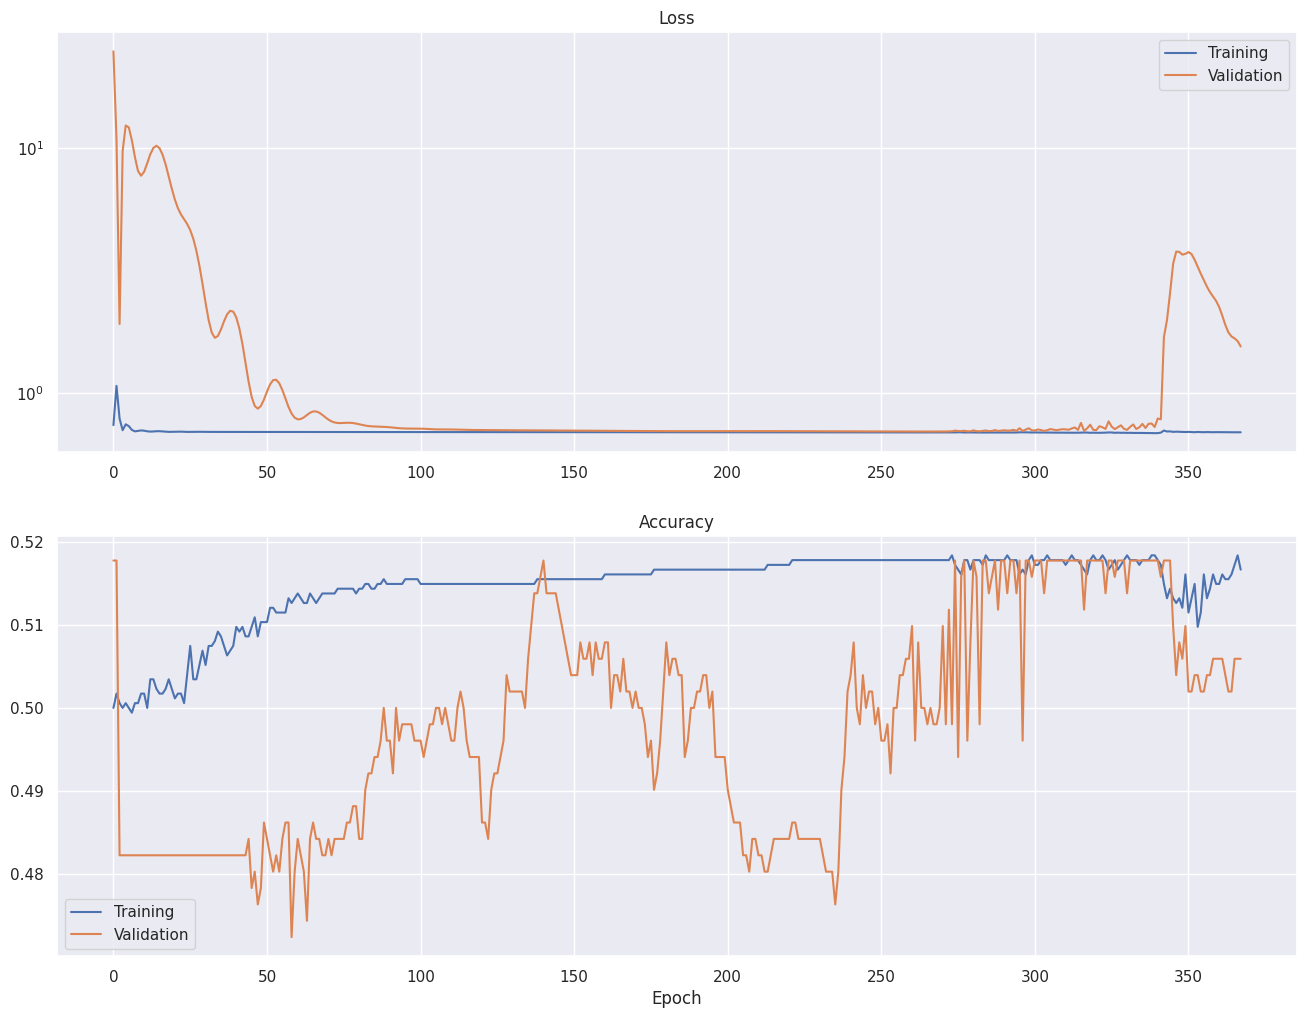

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#plt.style.use("seaborn-v0_8")
fig, axes=plt.subplots(2, 1, figsize=(16,12))

axes[0].set_title("Loss")
axes[0].set_yscale("log")
axes[0].plot(train_history.history["loss"], label="Training")
axes[0].plot(train_history.history["val_loss"], label="Validation")
axes[0].legend()

axes[1].set_title("Accuracy")
axes[1].plot(train_history.history["accuracy"], label="Training")
axes[1].plot(train_history.history["val_accuracy"], label="Validation")
axes[1].set_xlabel("Epoch")
axes[1].legend()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
